# Trend Following

This chapter demonstrates a simple trend-following strategy using Yahoo Finance data.  The methodology is inspired by the Meb Faber's paper *A Quantitative Approach to Tactical Asset Allocation*.  

The basic workflow to use this notebook is to set the parameters in the **Setting Parameters** section and then to run the `Restart Kernel and Run All Cells...` command in the `Kernel` dropdown menu.

The strategy we implement is quite straight forward.  On each trading day, we check if the current price is above or below the trailing simple moving average (SMA) of the prices (the number of days in the moving average is a parameter).  If the current price is above the SMA we go long the asset, if it is below the SMA we hold no position.  We compare this simple strategy to the buying and holding the asset, i.e. always being long the asset.

One major difference between our strategy and the one that is used in the aforementioned paper is that in our strategy, positions are recalculated on a daily basis.  In the paper, positions are recalculated at the end of each month, and then held fixed for the duration of the following month.  This will yield some differences in our results and the results in the paper. 

At the end of this chapter we analyze a particular case study in which we try to recreate Figure 9 from Faber's paper.

## Importing Packages

Let's begin by importing the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

## Setting Parameters

Next we set the parameters of our analysis.  The parameter `sma_days` determines the number of days used in the trailing simple moving average.

In [ ]:
ticker = '^SP500TR'
start_date = '1989-12-29'
end_date = '2012-01-01'
sma_days = 200

## Reading-In Data

We now read-in our data from Yahoo Finance.

[*********************100%***********************]  1 of 1 completed


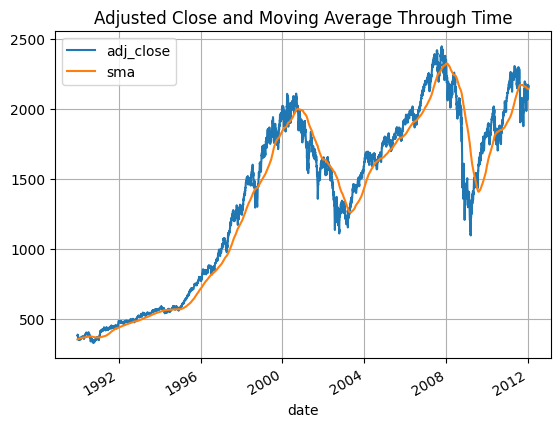

In [ ]:
df_asset = pdr.get_data_yahoo(ticker)
df_asset.reset_index(inplace=True)
df_asset.columns = df_asset.columns.str.lower().str.replace(' ','_')
df_asset = df_asset[['date', 'adj_close']].copy()
df_asset['sma'] = df_asset['adj_close'].rolling(sma_days).mean()
df_asset = df_asset.query('date >= @start_date and date <= @end_date').copy()
df_asset.plot(x='date', y=['adj_close', 'sma'], grid=True, title='Adjusted Close and Moving Average Through Time');

## Determining Position Based on Trend

Here we define the function that will help to determine our daily position in the asset.

In [ ]:
def calc_position(row):
    adj_close = row['adj_close']
    sma = row['sma']

    position = 0
    if sma < adj_close:
        position = 1

    return position

Let's now use the `DataFrame.apply()` method to calculate all the positions through time.

In [ ]:
df_asset['trend_position'] = df_asset.apply(calc_position, axis = 1)
df_asset

,date,adj_close,sma,trend_position
504,1989-12-29,379.410004,351.375200,1
505,1990-01-02,386.160004,351.776050,1
506,1990-01-03,385.170013,352.186400,1
507,1990-01-04,382.019989,352.573600,1
508,1990-01-05,378.299988,352.946600,1
...,...,...,...,...
6047,2011-12-23,2171.500000,2141.526601,1
6048,2011-12-27,2171.709961,2141.442350,1
6049,2011-12-28,2145.090088,2141.347501,1
6050,2011-12-29,2168.120117,2141.578401,1


## Calculating Returns, Equity Curves, and Drawdowns

We now have all the data the we need to calculate daily returns, the equity curves, and drawdowns of the two strategies.

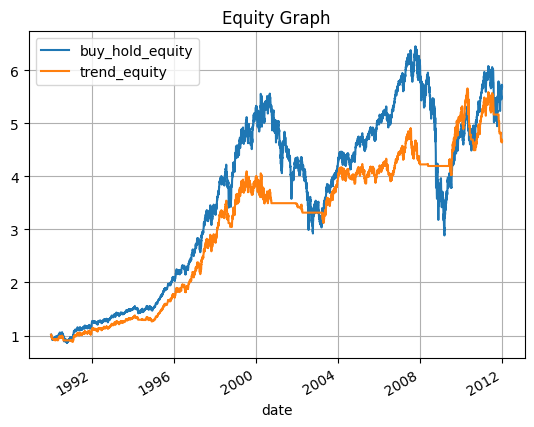

In [ ]:
# returns
df_asset['buy_hold_return'] = df_asset['adj_close'].pct_change()
df_asset['trend_return'] = df_asset['buy_hold_return'] * df_asset['trend_position'].shift(1)

# growth factors
df_asset['buy_hold_factor'] = 1 + df_asset['buy_hold_return']
df_asset['trend_factor'] = 1 + df_asset['trend_return']

# equity curves
df_asset['buy_hold_equity'] = df_asset['buy_hold_factor'].cumprod()
df_asset['trend_equity'] = df_asset['trend_factor'].cumprod()

# maximum cumulative equity
df_asset['buy_hold_max_equity'] = df_asset['buy_hold_equity'].cummax()
df_asset['trend_max_equity'] = df_asset['trend_equity'].cummax()

# draw-down
df_asset['buy_hold_drawdown'] = (df_asset['buy_hold_equity'] - df_asset['buy_hold_max_equity']) / df_asset['buy_hold_max_equity']
df_asset['trend_drawdown'] = (df_asset['trend_equity'] - df_asset['trend_max_equity']) / df_asset['trend_max_equity']

# graphing equity curves
df_asset.plot(x='date', y=['buy_hold_equity','trend_equity'], grid=True, title='Equity Graph');

## Return Characteristics

Finally, we calculate some basic performance metrics.

**Annualized Return**

In [ ]:
print('buy-hold return: ', np.round(df_asset['buy_hold_equity'].iloc[-1] ** (252 / (len(df_asset) - 1)) - 1, 3) * 100, '%')
print('trend return:    ', np.round(df_asset['trend_equity'].iloc[-1] ** (252 / (len(df_asset) - 1)) - 1, 3) * 100, '%')

buy-hold return:  8.200000000000001 %
trend return:     7.199999999999999 %


**Sharpe-Ratio**

In [ ]:
print('buy-hold sharpe-ratio: ', np.round((np.mean(df_asset['buy_hold_return']) / np.std(df_asset['buy_hold_return'])) * np.sqrt(252), 2))
print('trend sharpe-ratio:    ', np.round((np.mean(df_asset['trend_return']) / np.std(df_asset['trend_return'])) * np.sqrt(252), 2))

buy-hold sharpe-ratio:  0.51
trend sharpe-ratio:     0.66


**Maximum Drawdown**

In [ ]:
print('buy-hold max-drawdown: ', np.round(np.min(df_asset['buy_hold_drawdown']), 2))
print('trend max-drawdown:    ', np.round(np.min(df_asset['trend_drawdown']), 2))

buy-hold max-drawdown:  -0.55
trend max-drawdown:     -0.24


## Case Study: S&P500 1990-2012

Let's now take a look at a particular case study of the S&P500 in the period of 1990-2012.  We will use the Total Returns futures to represent an investment in the S&P500.  In order to get the result we describe, rerun this notebook with the following inputs:

`ticker = '^SP500TR'`

`start_date = '1989-12-29'`

`end_date = '2012-01-01'`

`sma_days = 200`


We first compare our equity graph above to Faber's equity graph which we present below:

![](images/meb_faber_equity_graph.png)

As we can see in Faber's analysis, trend-following slightly outperforms the buy-and-hold strategy, while in our analysis the trend-following strategy underperforms.  This difference is likely due to the difference in rebalance frequency.  Our strategy rebalances daily (which is probably too much) while Faber's rebalances monthly.

Analyzing our results more closely, we see that buy-and-hold has an annualized return of 8.2%, while trend-following has an annualized return of 7.2%.  There is, however, significantly less downside risk with trend-following, as the strategy tends to sit-out bear markets (e.g. 2000 and 2008).  This results in a max-drawdown of -24% for trend following, while buy-and-hold had a max-drawdown of -55% during the 2008 financial crisis.  This reduced downside risk can also be seen in the Sharpe-ratio, a metric by which trend-following (0.66) outperforms buy-and-hold (0.51).